In [1]:
import numpy as np
import cv2
import struct
import math
import time
import os
import math
import time
import sys
import PIL
from models import *
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

#from models import *
import torch.nn as nn
import torch.nn.functional as F
import torch

from torchvision import models
from torchvision.models.vgg import VGG

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import scipy.misc
import random
import sys
from tqdm import tqdm

In [2]:
class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace = True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score

class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):      
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x
        return output
    
ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [3]:
class DownsamplerBlock (nn.Module):
    def __init__(self, ninput, noutput):
        super().__init__()

        self.conv = nn.Conv2d(ninput, noutput-ninput, (3, 3), stride=2, padding=1, bias=True)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.bn = nn.BatchNorm2d(noutput, eps=1e-3)

    def forward(self, input):
        output = torch.cat([self.conv(input), self.pool(input)], 1)
        output = self.bn(output)
        return F.relu(output)
    

class non_bottleneck_1d (nn.Module):
    def __init__(self, chann, dropprob, dilated):        
        super().__init__()

        self.conv3x1_1 = nn.Conv2d(chann, chann, (3, 1), stride=1, padding=(1,0), bias=True)

        self.conv1x3_1 = nn.Conv2d(chann, chann, (1,3), stride=1, padding=(0,1), bias=True)

        self.bn1 = nn.BatchNorm2d(chann, eps=1e-03)

        self.conv3x1_2 = nn.Conv2d(chann, chann, (3, 1), stride=1, padding=(1*dilated,0), bias=True, dilation = (dilated,1))

        self.conv1x3_2 = nn.Conv2d(chann, chann, (1,3), stride=1, padding=(0,1*dilated), bias=True, dilation = (1, dilated))

        self.bn2 = nn.BatchNorm2d(chann, eps=1e-03)

        self.dropout = nn.Dropout2d(dropprob)
        

    def forward(self, input):

        output = self.conv3x1_1(input)
        output = F.relu(output)
        output = self.conv1x3_1(output)
        output = self.bn1(output)
        output = F.relu(output)

        output = self.conv3x1_2(output)
        output = F.relu(output)
        output = self.conv1x3_2(output)
        output = self.bn2(output)

        if (self.dropout.p != 0):
            output = self.dropout(output)
        
        return F.relu(output+input)    #+input = identity (residual connection)


class Encoder(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.initial_block = DownsamplerBlock(9,16)

        self.layers = nn.ModuleList()

        self.layers.append(DownsamplerBlock(16,64))

        for x in range(0, 5):    #5 times
            self.layers.append(non_bottleneck_1d(64, 0.03, 1)) 

        self.layers.append(DownsamplerBlock(64,128))

        for x in range(0, 2):    #2 times
            self.layers.append(non_bottleneck_1d(128, 0.3, 2))
            self.layers.append(non_bottleneck_1d(128, 0.3, 4))
            self.layers.append(non_bottleneck_1d(128, 0.3, 8))
            self.layers.append(non_bottleneck_1d(128, 0.3, 16))

        #Only in encoder mode:
        self.output_conv = nn.Conv2d(128, n_class, 1, stride=1, padding=0, bias=True)

    def forward(self, input, predict=False):
        output = self.initial_block(input)

        for layer in self.layers:
            output = layer(output)

        if predict:
            output = self.output_conv(output)

        return output


class UpsamplerBlock (nn.Module):
    def __init__(self, ninput, noutput):
        super().__init__()
        self.conv = nn.ConvTranspose2d(ninput, noutput, 3, stride=2, padding=1, output_padding=1, bias=True)
        self.bn = nn.BatchNorm2d(noutput, eps=1e-3)

    def forward(self, input):
        output = self.conv(input)
        output = self.bn(output)
        return F.relu(output)

class Decoder (nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.layers = nn.ModuleList()

        self.layers.append(UpsamplerBlock(128,64))
        self.layers.append(non_bottleneck_1d(64, 0, 1))
        self.layers.append(non_bottleneck_1d(64, 0, 1))

        self.layers.append(UpsamplerBlock(64,16))
        self.layers.append(non_bottleneck_1d(16, 0, 1))
        self.layers.append(non_bottleneck_1d(16, 0, 1))

        self.output_conv = nn.ConvTranspose2d( 16, n_class, 2, stride=2, padding=0, output_padding=0, bias=True)

    def forward(self, input):
        output = input

        for layer in self.layers:
            output = layer(output)

        output = self.output_conv(output)

        return output

#ERFNet
class ERFNet(nn.Module):
    def __init__(self, n_class, encoder=None):  #use encoder to pass pretrained encoder
        super().__init__()

        if (encoder == None):
            self.encoder = Encoder(n_class)
        else:
            self.encoder = encoder
        self.decoder = Decoder(n_class)

    def forward(self, input, only_encode=False):
        if only_encode:
            return self.encoder.forward(input, predict=True)
        else:
            output = self.encoder(input)    #predict=False by default
            return self.decoder.forward(output)

In [4]:
means = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
h, w  = 480, 640
n_class = 5
FullPath = os.getcwd()
fcn_model_dir = os.path.join(FullPath + "/models/pst_gan")
fcn_model_name = "FCNs_batch4_epoch80_RMSprop_lr0.0001.pkl"

vgg_model = VGGNet(cfg, requires_grad=True, remove_fc=True)
fcn_model = FCN16s(pretrained_net=vgg_model, n_class=n_class)
erfnet_model = ERFNet(n_class=n_class)

use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

if use_gpu:
    ts = time.time()
    vgg_model = vgg_model.cuda()
    fcn_model = fcn_model.cuda()
    fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
    erfnet_model = erfnet_model.cuda()
    print("Finish cuda loading, time elapsed {}".format(time.time() - ts))


mask1 = np.zeros((h, w))
MAXAREA = 18000
MINAREA = 1000

Finish cuda loading, time elapsed 3.8154914379119873


In [5]:
means     = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
h, w      = 480, 640
val_h     = h
val_w     = w

class product_dataset(Dataset):

    def __init__(self, root, phase, n_class=n_class, flip_rate=0.):
        data_dir = os.path.join(root, phase)
        self.img_list = os.listdir(os.path.join(data_dir, 'rgb'))
        self.rgb_dir = os.path.join(data_dir, 'rgb')
        self.label_dir = os.path.join(data_dir, 'labels')
        self.thermal_dir = os.path.join(data_dir, 'thermal')
        self.means     = means
        self.n_class   = n_class
        self.flip_rate = flip_rate
        if phase == 'train':
            self.flip_rate = 0.5
            
        
    def __len__(self):
        return len(self.img_list)    
    
    def __getitem__(self, idx):
        idx = idx % len(self.img_list)    
        img = cv2.imread(os.path.join(self.rgb_dir, self.img_list[idx]),cv2.IMREAD_UNCHANGED)
        label = cv2.imread(os.path.join(self.label_dir, self.img_list[idx]), cv2.IMREAD_GRAYSCALE)
        thermal = cv2.imread(os.path.join(self.thermal_dir, self.img_list[idx]), cv2.IMREAD_GRAYSCALE)
        
        
        img = cv2.resize(img, (640, 480), interpolation=cv2.INTER_CUBIC)
        label = cv2.resize(label, (640, 480), interpolation=cv2.INTER_CUBIC)
        thermal = cv2.resize(thermal, (640, 480), interpolation=cv2.INTER_CUBIC)
                                              
                             
        origin_img = img
        origin_thermal = thermal
        
        if random.random() < self.flip_rate:
            img   = np.fliplr(img)
            label = np.fliplr(label)
            thermal = np.fliplr(thermal)

        # reduce mean
        img = img[:, :, ::-1]  # switch to BGR
        
        img = np.transpose(img, (2, 0, 1)) / 255.
        img[0] -= self.means[0]
        img[1] -= self.means[1]
        img[2] -= self.means[2]

        # convert to tensor
        img = torch.from_numpy(img.copy()).float()
        label = torch.from_numpy(label.copy()).long()
        thermal = torch.from_numpy(thermal.copy()).float()
        thermal = torch.unsqueeze(thermal,0)

        # create one-hot encoding
        h, w = label.size()
        
        target = torch.zeros(self.n_class, h, w)
        
        for i in range(n_class):
            target[i][label == i] = 1
        
        #target[0][label == 0] = 1
        #print(np.unique(label))

 
        sample = {'X': img, 'Y': target, 'l': label, 'origin': origin_img, 'T': thermal, 'origin_T': origin_thermal}

        return sample

In [6]:
def prediction(model_name):
    
    fcn_state_dict = torch.load(os.path.join(fcn_model_dir, fcn_model_name))
    fcn_model.load_state_dict(fcn_state_dict)
    erfnet_state_dict = torch.load(os.path.join(model_name))
    erfnet_model.load_state_dict(erfnet_state_dict)
     
    batch = dataiter.next()
    if use_gpu:
        inputs = Variable(batch['X'].cuda())
        thermals = Variable(batch['T'].cuda())
    else:
        inputs = Variable(batch['X'])
        thermals = Variable(batch['T'])
    
    origin_T = batch['origin_T']    
    img    = batch['origin'] 
    label  = batch['l']
    
    
    #print(img.shape, inputs.shape)
    #print(inputs[0])
        
    output = fcn_model(inputs)
    #output = output.data.cpu().numpy()
    new_input = torch.cat((inputs,output,thermals), dim=1, out=None)
    new_output = erfnet_model(new_input)
    new_output = new_output.data.cpu().numpy()

    N, _, h, w = new_output.shape
    pred = new_output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)

    # show images
    plt.figure(figsize = (10, 12))
    img = img.numpy()
    for i in range(N):
        img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
        plt.subplot(N, 4, i*3 + 1)
        plt.title("origin_img")
        plt.imshow(img[i])
        #print(np.unique(_img[i]))

        plt.subplot(N, 4, i*3 + 2)
        plt.title("label_img")
        plt.imshow(label[i],cmap = "nipy_spectral",vmin = 0, vmax = n_class - 1)

        plt.subplot(N, 4, i*3 + 3)
        plt.title("thermal")
        plt.imshow(origin_T[i],cmap = plt.cm.gray)
        
        plt.subplot(N, 4, i*3 + 4)
        plt.title("prediction")
        plt.imshow(pred[i],cmap = "nipy_spectral",vmin = 0, vmax = n_class - 1)

    
    pred_img = np.zeros((pred[0].shape[0], pred[0].shape[1]), np.uint8)
    for i in range(pred[0].shape[0]):
        for j in range(pred[0].shape[1]):
            if pred[0][i][j] == 1: #extinguisher
                pred_img[i][j] = 1
            elif pred[0][i][j] == 2: #backpack
                pred_img[i][j] = 2
            elif pred[0][i][j] == 3: #drill
                pred_img[i][j] = 3
            elif pred[0][i][j] == 4: #survivor
                pred_img[i][j] = 4
            elif pred[0][i][j] == 5: #delet phone
                pred_img[i][j] = 0
                
    #y = cv2.cvtColor(y, cv2.COLOR_GRAY2RGB)
    #plt.imsave("/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/models/pst/b_6.jpg", y, cmap='nipy_spectral',vmin = 0, vmax = n_class - 1)
    #cv2.imwrite("/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/models/pst/a.jpg", y)
    plt.show()
    return pred_img

In [7]:
def val(data_dir, score_dir, name):
    
    if not os.path.exists(score_dir):
        os.makedirs(score_dir)
        
    TP = np.zeros(n_class-1, dtype = np.float128)
    FN = np.zeros(n_class-1, dtype = np.float128)
    FP = np.zeros(n_class-1, dtype = np.float128)
    total_ious = []
    pixel_accs = []
    
    for iter, batch in enumerate(tqdm(val_loader)):
        if use_gpu:
            inputs = Variable(batch['X'].cuda())
            thermals = Variable(batch['T'].cuda())
        else:
            inputs = Variable(batch['X'])
            thermals = Variable(batch['T'])

        output = fcn_model(inputs)
        new_input = torch.cat((inputs,output,thermals), dim=1, out=None)
        new_output = erfnet_model(new_input)
        new_output = new_output.data.cpu().numpy()

        N, _, h, w = new_output.shape
        pred = new_output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)
        
        target = batch['l'].cpu().numpy().reshape(N, h, w)
        for p, t in zip(pred, target):
            pixel_accs.append(pixel_acc(p, t))
            _TP, _FN, _FP =  analysis(p, t, h, w)
            TP += _TP[1:n_class]
            FN += _FN[1:n_class]
            FP += _FP[1:n_class]
            
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    ious = TP / (TP + FN + FP)
    fscore = 2*TP / (2*TP + FN + FP)
    total_ious = np.array(total_ious).T  # n_class * val_len
    pixel_accs = np.array(pixel_accs).mean()
    
    
    print("name: {}, pix_acc: {}, meanIoU: {}, IoUs: {}, recall: {}, precision: {}, fscore: {}"\
          .format(name, pixel_accs, np.nanmean(ious), ious, recall, precision, fscore))
    
    f1 = open(score_dir + "/cls_acc_log.txt","a+")
    f1.write('name:'+ str(name) + ', pix_acc: ' + str(pixel_accs) + '\n' )
    f2 = open(score_dir + "/cls_iou_log.txt","a+")
    f2.write('name:'+ str(name) + ', class ious: ' + str(ious) + '\n' )
    f3 = open(score_dir + "/mean_iou_log.txt","a+")
    f3.write('name:'+ str(name) + ', mean IoU: ' + str(np.nanmean(ious)) + '\n' ) 
    f4 = open(score_dir + "/recall_log.txt","a+")
    f4.write('name:'+ str(name) + ', class recall: ' + str(recall) + '\n' )
    f5 = open(score_dir + "/precision_log.txt","a+")
    f5.write('name:'+ str(name) + ', class precision: ' + str(precision) + '\n' )    
    f6 = open(score_dir + "/fscore_log.txt","a+")
    f6.write('name:'+ str(name) + ', class fscore: ' + str(fscore) + '\n' )
    f7 = open(score_dir + "/mean_fscore_log.txt","a+")
    f7.write('name:'+ str(name) + ', mean fscore: ' + str(np.nanmean(fscore)) + '\n' )
    f8 = open(score_dir + "/mean_precision_log.txt","a+")
    f8.write('name:'+ str(name) + ', mean precision: ' + str(np.nanmean(precision)) + '\n' ) 
    f9 = open(score_dir + "/mean_recall_log.txt","a+")
    f9.write('name:'+ str(name) + ', mean recall: ' + str(np.nanmean(recall)) + '\n' ) 
    

def analysis(pred, target, h, w):
    # TP, FN, FP, TN
    TP = np.zeros(n_class, dtype = np.float128)
    FN = np.zeros(n_class, dtype = np.float128)
    FP = np.zeros(n_class, dtype = np.float128)

    target = target.reshape(h * w)
    pred = pred.reshape(h * w)

    con_matrix = confusion_matrix(target, pred,labels = np.arange(0,n_class,1))
    con_matrix[0][0] = 0
    for i in range(0, n_class):
        for j in range(0, n_class):
            if i == j:
                TP[i] += con_matrix[i][j]
            if i != j:
                FP[j] += con_matrix[i][j]
                FN[i] += con_matrix[i][j]
    return TP, FN, FP
                
def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

In [12]:
name = "ERFNet_batch3_epoch164_Adam_lr0.0005"

data_dir = os.path.join(FullPath + "/data/PST900_RGBT_Dataset")
score_dir = os.path.join(FullPath + "/scores/evaluate_ERFNet")
ERFNet_model = os.path.join(FullPath + "/models/ERFNet_dual_stream/" + name + ".pkl")

val_data   = product_dataset(data_dir, phase = 'test', flip_rate = 0)
val_loader = DataLoader(val_data, batch_size = 1, num_workers = 0)
dataiter = iter(val_loader)

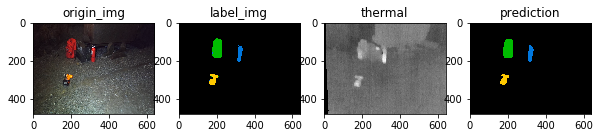

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [13]:
prediction(ERFNet_model)

In [14]:
val(data_dir, score_dir, name)

100%|██████████| 288/288 [01:02<00:00,  4.63it/s]

name: ERFNet_batch3_epoch164_Adam_lr0.0005, pix_acc: 0.9942670468930844, meanIoU: 0.7548900192123009, IoUs: [0.7300696  0.81095537 0.82117162 0.65736349], recall: [0.79976916 0.83736618 0.85450187 0.96253613], precision: [0.89335835 0.96256321 0.95465414 0.67462438], fscore: [0.84397714 0.89561055 0.90180586 0.79326411]
